In [1]:
from pyosrd import OSRD
from pyosrd.schedules import schedule_from_osrd, step_has_fixed_duration, step_station_id, step_type

In [2]:
sim = OSRD(use_case='station_capacity2', dir='/tmp')

[16:00:37,586] [INFO]  [StandaloneSimulationCommand] Loading infra: /tmp/infra.json
[16:00:37,620] [INFO]              [FullInfra] parsing infra
[16:00:37,683] [INFO]              [FullInfra] adaptation to kotlin
[16:00:37,717] [INFO]              [FullInfra] loading signals
[16:00:37,723] [INFO]              [FullInfra] building blocks
[16:00:37,728] [INFO]  [StandaloneSimulationCommand] Loading input: /tmp/simulation.json
[16:00:37,740] [INFO]  [StandaloneSimulationCommand] Running simulation for schedule group: group.0
[16:00:37,787] [INFO]  [StandaloneSimulationCommand] Running simulation for schedule group: group.1
[16:00:37,793] [INFO]  [StandaloneSimulationCommand] All simulations completed
[16:00:37,793] [INFO]  [StandaloneSimulationCommand] Saving results at: /tmp/results.json


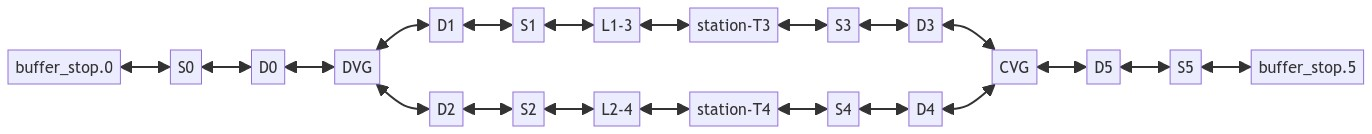

In [3]:
sim.draw_infra_points()

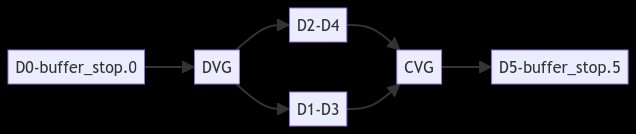

In [4]:
schedule = schedule_from_osrd(sim)
schedule.draw_graph()

<Axes: xlabel='Time'>

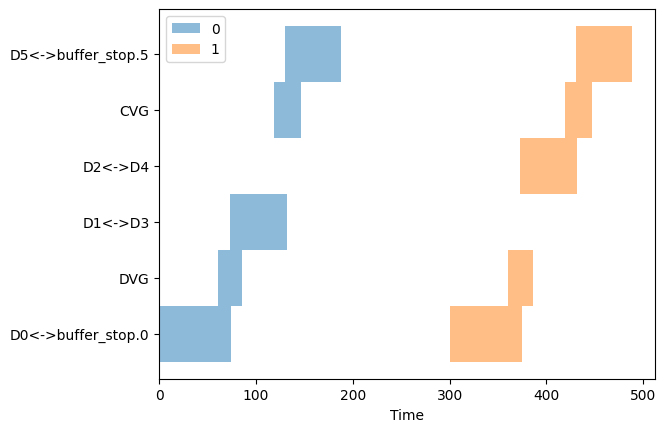

In [5]:
schedule.plot()

# Infos supplémentaires sur les zones
Peuvent être utiles aux agents

In [6]:
display(step_has_fixed_duration(sim))
display(step_station_id(sim))
display(step_type(sim))

,0,1
D0<->buffer_stop.0,False,False
DVG,True,True
D1<->D3,False,NaN
D2<->D4,NaN,False
CVG,True,True
D5<->buffer_stop.5,True,True


,0,1
D0<->buffer_stop.0,NaN,NaN
DVG,NaN,NaN
D1<->D3,station,NaN
D2<->D4,NaN,station
CVG,NaN,NaN
D5<->buffer_stop.5,NaN,NaN


,0,1
D0<->buffer_stop.0,signal,signal
DVG,switch,switch
D1<->D3,station,NaN
D2<->D4,NaN,station
CVG,switch,switch
D5<->buffer_stop.5,last_zone,last_zone


# Weights
Construire des matrices de pondération pour les passer à un agent qui s'en servira pour le calcul d'un retard pondéré

In [7]:
import pyosrd.schedules.weights as weights

display(weights.stations_only(sim))
display(weights.all_steps(sim))

,0,1
D0<->buffer_stop.0,0,0
DVG,0,0
D1<->D3,1,0
D2<->D4,0,1
CVG,0,0
D5<->buffer_stop.5,0,0


,0,1
D0<->buffer_stop.0,1,1
DVG,1,1
D1<->D3,1,0
D2<->D4,0,1
CVG,1,1
D5<->buffer_stop.5,1,1


In [8]:
w = weights.stations_only(sim)
w.weights.train(0, 2)
w.weights.train_zone(1, 'D0<->buffer_stop.0', 5)
w.weights.train_station_sim(1, 'station', 7, sim)
w

/home/renan/RLway/src/pyosrd/schedules/weights.py:68: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  osrd._obj[train].loc[zone] = value
/home/renan/RLway/src/pyosrd/schedules/weights.py:68: FutureWarning: ChainedAssignmentError: behaviour wil

,0,1
D0<->buffer_stop.0,0,5
DVG,0,0
D1<->D3,2,0
D2<->D4,0,7
CVG,0,0
D5<->buffer_stop.5,0,0


# Scheduler Agents
C'est une classe abstraite qui a tous les outils pour travailler avec des schedules
1. de manière autonome à partir d'une simulation,
2. ou dans la méthode regulate(),
3. ou encore de manière autonome à partir de schedules custom.

Une classe concrète doit avoir une méthode qui renvoie les délais ajoutés pour chaque couple (zone, train) sous forme d'un dataframe avec les mêmes dimensions qu'un schedule.
```python3
@property
def steps_extra_delays(self) -> pd.DataFrame
```


## 1. de manière autonome à partir d'une simulation

In [9]:
from pyosrd.agents.scheduler_agent import SchedulerAgent
import pandas as pd

class DummySchedulerAgent(SchedulerAgent):
    @property
    def steps_extra_delays(self) -> pd.DataFrame:
        """As an example, make train1 stop 60s more at station"""
        extra_delays = self.initial_schedule.durations * 0.
        extra_delays.iloc[3][1] = 60.
        return extra_delays

sim.reset_delays()
sim.add_delay('train0', time_threshold=90, delay=280.)
agent = DummySchedulerAgent('from_sim')
agent.set_schedules_from_osrd(sim)


In [10]:
display(agent.step_has_fixed_duration)
display(agent.weights)

,0,1
D0<->buffer_stop.0,False,False
DVG,True,True
D1<->D3,False,NaN
D2<->D4,NaN,False
CVG,True,True
D5<->buffer_stop.5,True,True


,0,1
D0<->buffer_stop.0,0,0
DVG,0,0
D1<->D3,1,0
D2<->D4,0,1
CVG,0,0
D5<->buffer_stop.5,0,0


/tmp/ipykernel_16640/3671597041.py:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  extra_delays.iloc[3][1] = 60.
/tmp/ipykernel_16640/3671597041.py:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setti

<Axes: xlabel='Time'>

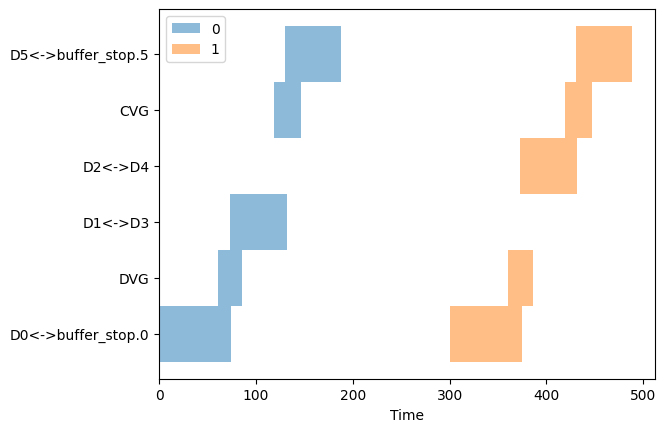

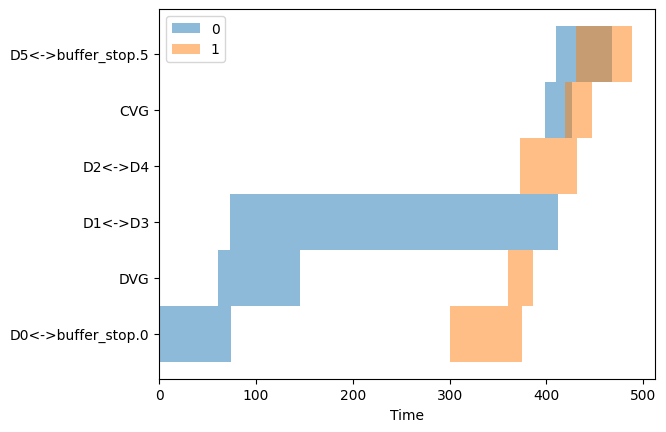

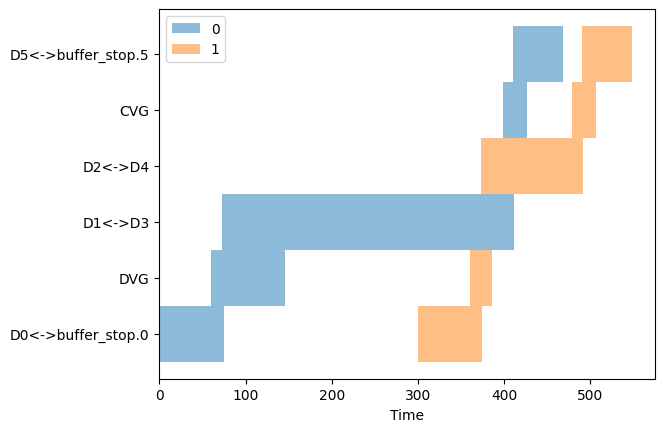

In [11]:
agent.initial_schedule.plot()
agent.delayed_schedule.plot()
agent.regulated_schedule.plot()

In [12]:
agent.steps_extra_delays

/tmp/ipykernel_16640/3671597041.py:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  extra_delays.iloc[3][1] = 60.


,0,1
D0<->buffer_stop.0,0.0,0.0
DVG,0.0,0.0
D1<->D3,0.0,NaN
D2<->D4,NaN,60.0
CVG,0.0,0.0
D5<->buffer_stop.5,0.0,0.0


## 2. via la méthode regulate de la classe OSRD()

/tmp/ipykernel_16640/3671597041.py:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  extra_delays.iloc[3][1] = 60.
/tmp/ipykernel_16640/3671597041.py:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setti

[16:00:40,077] [INFO]  [StandaloneSimulationCommand] Loading infra: /tmp/infra.json
[16:00:40,112] [INFO]              [FullInfra] parsing infra
[16:00:40,174] [INFO]              [FullInfra] adaptation to kotlin
[16:00:40,207] [INFO]              [FullInfra] loading signals
[16:00:40,213] [INFO]              [FullInfra] building blocks
[16:00:40,218] [INFO]  [StandaloneSimulationCommand] Loading input: /tmp/delayed/from_sim/simulation.json
[16:00:40,230] [INFO]  [StandaloneSimulationCommand] Running simulation for schedule group: group.0
[16:00:40,279] [INFO]  [StandaloneSimulationCommand] Running simulation for schedule group: group.1
[16:00:40,286] [INFO]  [StandaloneSimulationCommand] All simulations completed
[16:00:40,286] [INFO]  [StandaloneSimulationCommand] Saving results at: /tmp/delayed/from_sim/results.json


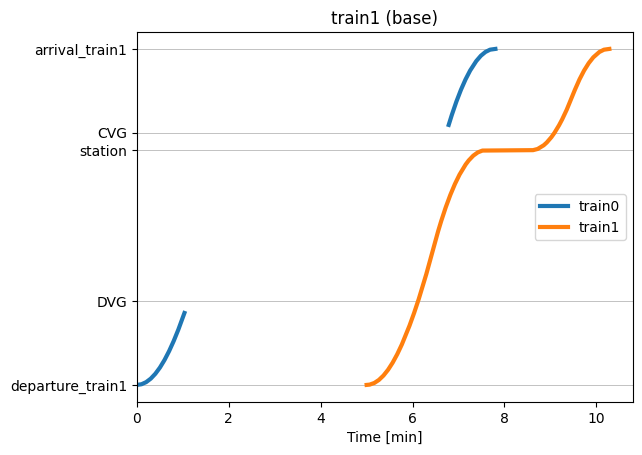

In [13]:
sim.regulate(agent=agent).space_time_chart(1);

## 3. de manière autonome à partir de schedules custom

In [14]:
from pyosrd.schedules import Schedule

schedule = Schedule(6, 2)

schedule.df.at[0, 0] = [0, 1]
schedule.df.at[2, 0] = [1, 2]
schedule.df.at[3, 0] = [2, 3]
schedule.df.at[4, 0] = [3, 4]

schedule.df.at[1, 1] = [1, 2]
schedule.df.at[2, 1] = [2, 3]
schedule.df.at[3, 1] = [3, 4]
schedule.df.at[5, 1] = [4, 5]

delayed = schedule.add_delay(0, 2, .5)

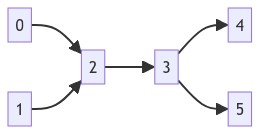

In [15]:
schedule.draw_graph()

<Axes: xlabel='Time'>

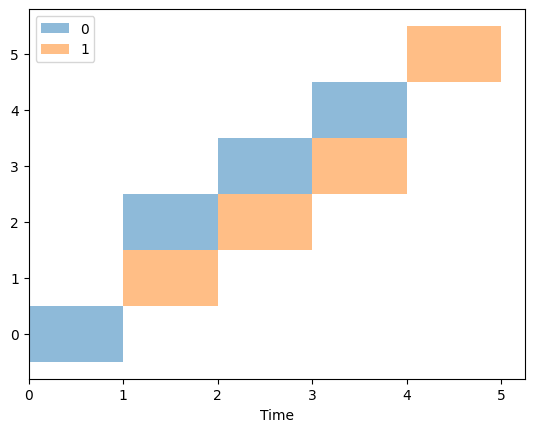

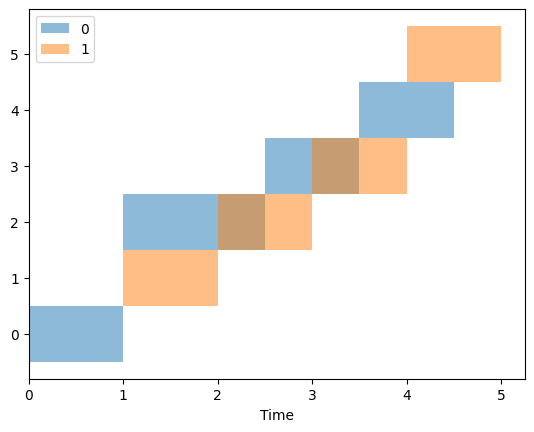

In [16]:
schedule.plot()
delayed.plot()

In [17]:
class TestSchedulerAgent(SchedulerAgent):
    @property
    def steps_extra_delays(self) -> pd.DataFrame:
        """As an example, make train0 star 1 time unit later"""
        extra_delays = self.initial_schedule.durations * 0.
        extra_delays.iloc[1][1] = 1.
        return extra_delays
    
agent=TestSchedulerAgent(
    'directly_from_schedules',
    initial_schedule=schedule,
    delayed_schedule=delayed,
    # one could had fixed duration zones and/or weights
)

In [18]:
agent.steps_extra_delays

/tmp/ipykernel_16640/2035889366.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  extra_delays.iloc[1][1] = 1.


,0,1
0,0.0,NaN
1,NaN,1.0
2,0.0,0.0
3,0.0,0.0
4,0.0,NaN
5,NaN,0.0


/tmp/ipykernel_16640/2035889366.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  extra_delays.iloc[1][1] = 1.
/tmp/ipykernel_16640/2035889366.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are settin

<Axes: xlabel='Time'>

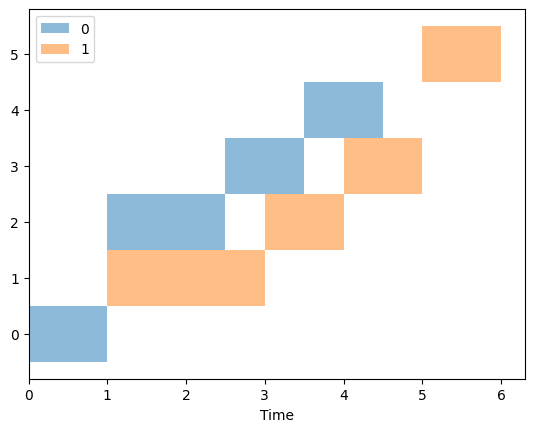

In [19]:
agent.regulated_schedule.plot()